# Species distribution modeling with ensemble model

## 1. Setup

### 1.1 Install dependencies

In [1]:
!pip install -U -q torch==2.5.0 torchvision matplotlib tqdm gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 822.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 814.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install scikit-multilearn
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.6 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, label_ranking_loss, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

### 1.2 Check if cuda available

In [4]:
print(torch.cuda.is_available())

True


## 2. Data loading

### 2.1 Mounting drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.1 Downloading data

In [6]:
base_path = "/content/drive/MyDrive/IPEO/Project"

os.chdir(base_path)
os.getcwd()

'/content/drive/MyDrive/IPEO/Project'

In [7]:
env_train = pd.read_csv(base_path + "/data/env_variables_training.csv")
env_test  = pd.read_csv(base_path + "/data/env_variables_test.csv")

ts_train  = pd.read_csv(base_path + "/data/landsat_timeseries_training.csv")
ts_test   = pd.read_csv(base_path + "/data/landsat_timeseries_test.csv")

# ---- Numpy files ----
img_train = np.load(base_path + "/data/satellite_patches_training.npy")
img_test  = np.load(base_path + "/data/satellite_patches_test.npy")

species_train = np.load(base_path + "/data/species_data_training.npy")
species_test  = np.load(base_path + "/data/species_data_test.npy")

print("Training shapes:")
print("Env:", env_train.shape)
print("Time-series:", ts_train.shape)
print("Images:", img_train.shape)
print("Labels:", species_train.shape)

Training shapes:
Env: (5000, 22)
Time-series: (5000, 161)
Images: (5000, 3, 128, 128)
Labels: (5000, 342)


### 2.2 Reshaping and removing columns

In [8]:
# Extract coordinates
train_lons = env_train.iloc[:, 1]
train_lats = env_train.iloc[:, 2]
test_lons = env_test.iloc[:, 1]
test_lats = env_test.iloc[:, 2]

env_train = env_train.values.astype(np.float32)
env_test  = env_test.values.astype(np.float32)

env_train = env_train[:, 3:]
env_test  = env_test[:, 3:]

mean_env = env_train.mean(axis=0)
std_env = env_train.std(axis=0)
env_train = (env_train - mean_env) / std_env
env_test = (env_test - mean_env) / std_env


ts_train = ts_train.values.astype(np.float32)
ts_test  = ts_test.values.astype(np.float32)

ts_train = ts_train[:, 1:161].reshape(-1, 40, 4)
ts_test  = ts_test[:, 1:161].reshape(-1, 40, 4)

mean_ts = ts_train.mean(axis=(0, 1))
std_ts = ts_train.std(axis=(0, 1))
ts_train = (ts_train - mean_ts) / std_ts
ts_test = (ts_test - mean_ts) / std_ts


img_train = img_train.astype(np.float32)/255.0
img_test  = img_test.astype(np.float32)/255.0

species_train = species_train.astype(np.float32)
species_test  = species_test.astype(np.float32)

### 2.3 Defining dataset class

In [9]:
class GeoPlantDataset(Dataset):
    def __init__(self, images, timeseries, tabular, labels, split='train', val_split=0.2, random_state=42):
        """
        Args:
            images: numpy array of satellite images
            timeseries: numpy array of time series data
            tabular: numpy array of environmental variables
            labels: numpy array of species labels
            split: 'train', 'val', or 'test'
            val_split: fraction of training data to use for validation (default 0.2)
            random_state: random seed for reproducibility
        """
        self.split = split

        if split == 'test' or split is None:
            self.images = images
            self.timeseries = timeseries
            self.tabular = tabular
            self.labels = labels
        else:
            indices = np.arange(len(labels))
            train_idx, val_idx = train_test_split(
                indices,
                test_size=val_split,
                random_state=random_state
            )

            if split == 'train':
                self.images = images[train_idx]
                self.timeseries = timeseries[train_idx]
                self.tabular = tabular[train_idx]
                self.labels = labels[train_idx]
            elif split == 'val':
                self.images = images[val_idx]
                self.timeseries = timeseries[val_idx]
                self.tabular = tabular[val_idx]
                self.labels = labels[val_idx]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx])
        ts  = torch.tensor(self.timeseries[idx])
        tab = torch.tensor(self.tabular[idx])
        y   = torch.tensor(self.labels[idx])
        return img, ts, tab, y

### 2.4 Creating dataset

In [10]:
train_dataset = GeoPlantDataset(
    images=img_train,
    timeseries=ts_train,
    tabular=env_train,
    labels=species_train,
    split='train',
    val_split=0.2
)

val_dataset = GeoPlantDataset(
    images=img_train,
    timeseries=ts_train,
    tabular=env_train,
    labels=species_train,
    split='val',
    val_split=0.2
)

test_dataset = GeoPlantDataset(
    images=img_test,
    timeseries=ts_test,
    tabular=env_test,
    labels=species_test,
    split='test'
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 4000
Val samples: 1000
Test samples: 1000


### 2.5 Checking dimensions

In [11]:
img, ts, tab, y = train_dataset[0]

print("Image:", img.shape)
print("Time series:", ts.shape)
print("Tabular:", tab.shape)
print("Label:", y.shape)

Image: torch.Size([3, 128, 128])
Time series: torch.Size([40, 4])
Tabular: torch.Size([19])
Label: torch.Size([342])


## 3. Multimodal species distribution model

In [12]:
# ------------------------------------------------------------
# 3.1 TABULAR ENCODER (climate variables)
# ------------------------------------------------------------
class TabularEncoder(nn.Module):
    def __init__(self, in_features=19, out_features=342):
        super().__init__()
        self.net = nn.Sequential(
          nn.Linear(in_features, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Dropout(0.1),

          nn.Linear(64, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(0.2),

          nn.Linear(128, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(0.3),

          nn.Linear(256, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(),

          nn.Linear(512, out_features)
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3.2 TEMPORAL ENCODER (Landsat quarterly 10-year series)
#      Input shape: (batch, T=40, C=4)
# ------------------------------------------------------------
class TimeseriesEncoder(nn.Module):
    def __init__(self, in_channels=4, out_features=342):
        super().__init__()

        # Convolutional Backbone
        self.features = nn.Sequential(
            self._make_layer(in_channels, 32),
            self._make_layer(32, 64),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
            self._make_layer(256, 512),
        )

        # Pooling
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.2)

        # Projection Head
        self.fc = nn.Linear(512, out_features)



    def _make_layer(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_c), # Added for stability
            nn.ReLU()
        )


    def forward(self, ts):
        # ts shape: (B, T, C) -> (B, C, T)
        ts = ts.permute(0, 2, 1)

        x = self.features(ts)

        # Global Average Pool: (B, 512, T) -> (B, 512)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# ------------------------------------------------------------
# 3.3 IMAGE ENCODER (Sentinel-2 RGB patches)
#      Uses pretrained ResNet34 but outputs a 256-dim feature
# ------------------------------------------------------------
from torchvision.models import resnet34

class ImageEncoder(nn.Module):
    def __init__(self, num_species=342):
        super().__init__()
        # Load weights suited for natural images
        base = resnet34(weights="DEFAULT")

        # Keep everything except final FC layer
        self.backbone = nn.Sequential(*list(base.children())[:-1])

        # Add FC
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_species)
        )

    def forward(self, img):
        features = self.backbone(img)
        logits = self.head(features)
        return logits


In [13]:
os.getcwd()

'/content/drive/MyDrive/IPEO/Project'

In [16]:
tabular_weights = "Models/Climate_data/Climate_data_model.pth"
temporal_weights = "Models/Landsat_timeseries/Landsat_timeseries_model.pth"
image_weights    = "Models/Satellite_imagery/Satellite_imagery_model.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate encoders
tabular_encoder  = TabularEncoder()
temporal_encoder = TimeseriesEncoder()
image_encoder    = ImageEncoder()

# Load weights
tabular_encoder.load_state_dict(torch.load(tabular_weights, map_location=device, weights_only=True))
temporal_encoder.load_state_dict(torch.load(temporal_weights, map_location=device, weights_only=True))
image_encoder.load_state_dict(torch.load(image_weights, map_location=device, weights_only=True))

tabular_encoder  = tabular_encoder.to(device)
temporal_encoder = temporal_encoder.to(device)
image_encoder    = image_encoder.to(device)

In [22]:
def ensemble_predict(loader, tabular_model, temporal_model, image_model, model_weights=[0.34, 0.33, 0.33],device="cpu"):
    tabular_model.eval()
    temporal_model.eval()
    image_model.eval()

    weights = torch.tensor(model_weights, device=device)
    weights = weights / weights.sum()
    weights = weights.view(3, 1, 1)  # <<< fix broadcasting

    ensemble_probs = []

    with torch.no_grad():
        for img, ts, env, _ in loader:
            img = img.to(device).float()
            ts  = ts.to(device).float()
            env = env.to(device).float()

            # Model outputs (probabilities)
            img_probs = torch.sigmoid(image_model(img))    # (B, 342)
            ts_probs  = torch.sigmoid(temporal_model(ts))  # (B, 342)
            tab_probs = torch.sigmoid(tabular_model(env))  # (B, 342)

            # Stack along model dimension
            probs = torch.stack([img_probs, ts_probs, tab_probs], dim=0)  # (3, B, 342)

            # Weighted sum along model dimension
            batch_probs = (weights * probs).sum(dim=0)  # (B, 342)

            ensemble_probs.append(batch_probs.cpu())

    ensemble_probs = torch.cat(ensemble_probs, dim=0).numpy()
    print("Ensemble probs shape:", ensemble_probs.shape)

    return ensemble_probs




In [23]:
full_train_data = GeoPlantDataset(tabular=env_train,images=img_train, timeseries=ts_train, labels=species_train, split=None)
train_loader = DataLoader(full_train_data, batch_size=32, shuffle=True, num_workers=2)

pred_train = ensemble_predict(train_loader,
                     tabular_encoder, temporal_encoder, image_encoder,
                     model_weights=[0.34, 0.33, 0.33],
                     device=device)

Ensemble probs shape: (5000, 342)


In [24]:
def find_optimal_thresholds(y_true, probs):
    """
    Finds the best threshold for each of the 342 species.
    y_true: Ground truth labels (N, 342)
    probs: Training predictions of ensemble model(N, 342)
    """
    num_species = y_true.shape[1]
    best_thresholds = np.zeros(num_species)

    # Range of thresholds to test
    thresholds = np.linspace(0, 1, 100)

    print("Optimizing thresholds for 342 species...")

    for i in range(num_species):
        species_labels = y_true[:, i]
        species_probs = probs[:, i]

        # Default to 0.5
        if species_labels.sum() == 0:
            best_thresholds[i] = 0.5
            continue

        best_fbeta = -1
        best_thresh = 0.5

        for t in thresholds:
            preds = (species_probs >= t).astype(int)
            score = fbeta_score(species_labels, preds, beta=0.5, zero_division=0) # Use fbeta to raise precision

            if score > best_fbeta:
                best_fbeta = score
                best_thresh = t

        best_thresholds[i] = best_thresh

    print("Optimization complete.")
    return best_thresholds

In [25]:
opt_thresholds = find_optimal_thresholds(species_train, pred_train)

Optimizing thresholds for 342 species...
Optimization complete.


In [31]:
def test_ensemble_model(loader, tabular_model, temporal_model, image_model, model_weights=[0.34, 0.33, 0.30],device="cpu"):

    tabular_model.eval()
    temporal_model.eval()
    image_model.eval()

    weights = torch.tensor(model_weights, device=device)
    weights = weights / weights.sum()
    weights = weights.view(3, 1, 1)

    ensemble_probs = []
    labels = []

    with torch.no_grad():
        for img, ts, env, y in loader:
            img = img.to(device).float()
            ts  = ts.to(device).float()
            env = env.to(device).float()
            y = y.to(device).float()

            labels.append(y.cpu())

            # Model outputs (probabilities)
            img_probs = torch.sigmoid(image_model(img))    # (B, 342)
            ts_probs  = torch.sigmoid(temporal_model(ts))  # (B, 342)
            tab_probs = torch.sigmoid(tabular_model(env))  # (B, 342)

            # Stack along model dimension
            probs = torch.stack([img_probs, ts_probs, tab_probs], dim=0)  # (3, B, 342)

            # Weighted sum along model dimension
            batch_probs = (weights * probs).sum(dim=0)  # (B, 342)

            ensemble_probs.append(batch_probs.cpu())

    ensemble_probs = torch.cat(ensemble_probs, dim=0).numpy()
    print("Ensemble probs shape:", ensemble_probs.shape)

    labels = torch.cat(labels).numpy()

    return ensemble_probs, labels

In [45]:
test_ensemble_probs, test_labels = test_ensemble_model(test_loader, tabular_encoder, temporal_encoder, image_encoder, model_weights=[0.34, 0.33, 0.33],device=device)

Ensemble probs shape: (1000, 342)


In [46]:
def full_evaluation(preds, labels, opt_thresholds, binary_preds):
    macro_auc = roc_auc_score(labels, preds, average='macro')
    weighted_auc = roc_auc_score(labels, preds, average='micro')

    macro_avg_prec = average_precision_score(labels, preds, average='macro')
    weighted_avg_prec = average_precision_score(labels, preds, average='micro')

    macro_f1 = f1_score(labels, binary_preds, average='macro')
    weighted_f1 = f1_score(labels, binary_preds, average='micro')

    macro_precision = precision_score(labels, binary_preds, average='macro', zero_division=0)
    weighted_precision = precision_score(labels, binary_preds, average='micro', zero_division=0)

    macro_recall = recall_score(labels, binary_preds, average='macro')
    weighted_recall = recall_score(labels, binary_preds, average='micro')

    subset_acc = (binary_preds == labels).all(axis=1).mean()

    rank_loss = label_ranking_loss(labels, preds)

    return {
        "Macro ROC AUC": macro_auc,
        "Micro ROC AUC": weighted_auc,
        "Macro Average Precision": macro_avg_prec,
        "Micro Average Precision": weighted_avg_prec,
        "Macro Recall": macro_recall,
        "Micro Recall": weighted_recall,
        "Macro F1": macro_f1,
        "Micro F1": weighted_f1,
        "Macro Precision": macro_precision,
        "Micro Precision": weighted_precision,
        "Subset Accuracy": subset_acc,
        "Ranking Loss": rank_loss
    }


In [47]:
binary_preds = (test_ensemble_probs >= opt_thresholds).astype(int)

results = full_evaluation(test_ensemble_probs, test_labels, opt_thresholds, binary_preds)
print("Metrics for focal model:")
for k,v in results.items():
    print(k, ":", v)

Metrics for focal model:
Macro ROC AUC : 0.8549206821828172
Micro ROC AUC : 0.870446770501521
Macro Average Precision : 0.24280574755848022
Micro Average Precision : 0.2331035087634663
Macro Recall : 0.5511764470585531
Micro Recall : 0.7202667080167467
Macro F1 : 0.15468375107378698
Micro F1 : 0.1559575271750535
Macro Precision : 0.1646464495189956
Micro Precision : 0.08744599339213269
Subset Accuracy : 0.0
Ranking Loss : 0.11995548360283904


### Multilabel confusion matrix

In [48]:
from sklearn.metrics import multilabel_confusion_matrix

matrices = multilabel_confusion_matrix(test_labels, binary_preds)

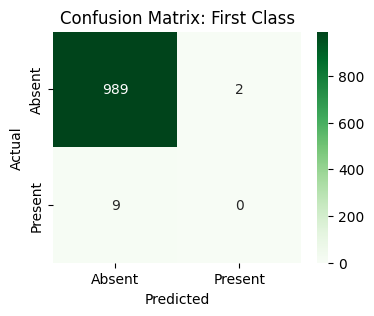

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns


first_class_matrix = matrices[9]
first_class_name = "First Class"

# 3. Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(first_class_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Absent', 'Present'],
            yticklabels=['Absent', 'Present'])

plt.title(f"Confusion Matrix: {first_class_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 7. Visualization on map

In [50]:
import folium
def map_predictions_species(preds, labels, species_index, test_lats, test_lons, show_types=None):
    """
    Creates a Folium map showing prediction correctness for a specific species.

    Parameters:
    - all_preds: np.array of shape (num_samples, num_species), model predictions (0/1)
    - all_labels: np.array of shape (num_samples, num_species), true labels (0/1)
    - species_index: int, index of the species to visualize
    - test_lats: list or array of latitude values
    - test_lons: list or array of longitude values
    - show_types: set of strings indicating which prediction types to show.
                  Options: 'TP', 'TN', 'FP', 'FN'
                  Default: None (show all)
    """

    print("Number of species prediction:")
    print(preds[:,species_index].sum())
    print("Number of species occurence:")
    print(labels[:,species_index].sum())

    if show_types is None:
        show_types = {'TP', 'TN', 'FP', 'FN'}  # show all by default

    center_lat = np.mean(test_lats)
    center_lon = np.mean(test_lons)
    fmap = folium.Map(location=[center_lat, center_lon], zoom_start=4)

    preds_species = preds[:, species_index]
    labels_species = labels[:, species_index]

    for lat, lon, pred, label in zip(test_lats, test_lons, preds_species, labels_species):
        # Determine prediction type and color
        if pred == 1 and label == 1:
            pred_type = 'TP'
            color = 'green'
        elif pred == 0 and label == 1:
            pred_type = 'FN'
            color = 'red'
        elif pred == 0 and label == 0:
            pred_type = 'TN'
            color = 'blue'
        else:  # pred == 1 and label == 0
            pred_type = 'FP'
            color = 'orange'

        if pred_type not in show_types:
            continue  # skip this point if not in selected types

        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.6
        ).add_to(fmap)

    return fmap

In [58]:
map_predictions_species(preds=binary_preds, labels=test_labels, species_index=30, test_lats=test_lats, test_lons=test_lons)

Number of species prediction:
60
Number of species occurence:
46.0
